**Importing Libraries**

In [1]:
#Functional libraries
import yfinance as yf
import numpy as np
import pandas as pd

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Machine learning libraries
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score

**Creating The Dataset**

In [2]:
#Monthly apple stock data past 5 years
aapl_5y_monthly_data = yf.download("AAPL", period="5y", interval='1mo')

[*********************100%***********************]  1 of 1 completed


**Data Exploration**

In [3]:
aapl_5y_monthly_data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-01,51.607498,56.605000,51.055000,55.992500,54.180805,2170268400
2019-10-01,56.267502,62.437500,53.782501,62.189999,60.177773,2433210800
2019-11-01,62.384998,67.000000,62.290001,66.812500,64.650719,1793326000
2019-12-01,66.817497,73.492500,64.072502,73.412498,71.250435,2388794800
2020-01-01,74.059998,81.962502,73.187500,77.377502,75.098679,2934370400


In [4]:
#Checking for null data
aapl_5y_monthly_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
aapl_5y_monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-09-01 to 2024-08-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       60 non-null     float64
 1   High       60 non-null     float64
 2   Low        60 non-null     float64
 3   Close      60 non-null     float64
 4   Adj Close  60 non-null     float64
 5   Volume     60 non-null     int64  
dtypes: float64(5), int64(1)
memory usage: 3.3 KB


In [6]:
aapl_5y_monthly_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,60.000000,60.000000,60.000000,60.000000,60.000000,6.000000e+01
mean,141.232458,151.544583,133.016500,143.929708,142.127025,1.975403e+09
std,42.289438,43.186605,40.166348,42.122630,42.567165,9.113338e+08
min,51.607498,56.605000,51.055000,55.992500,54.180805,9.518102e+08
25%,122.997503,133.302505,114.130625,121.927502,119.492598,1.337324e+09
50%,147.520004,157.320000,136.879997,148.434998,146.598442,1.724416e+09
75%,171.197502,180.930000,164.137501,172.262497,171.325375,2.338841e+09
max,224.369995,237.229996,211.919998,226.839996,226.839996,6.280072e+09


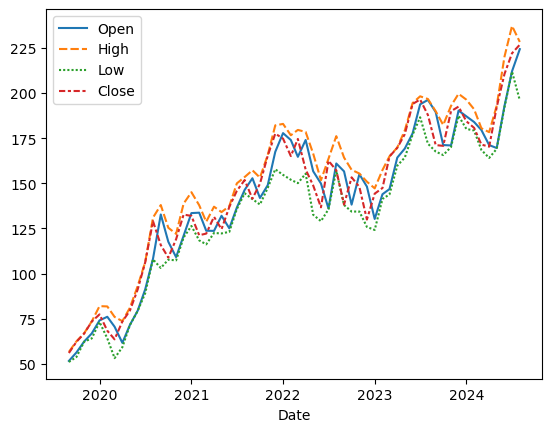

In [7]:
sns.lineplot(data=aapl_5y_monthly_data.drop(['Volume', 'Adj Close'], axis=1));

In [8]:
corr_matrix = aapl_5y_monthly_data.drop('Volume', axis=1).corr()

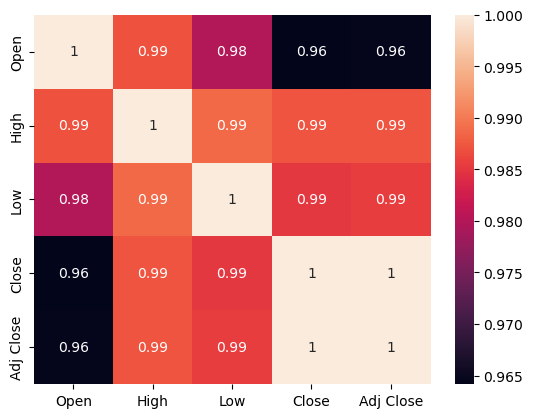

In [9]:
#Checking for correlations
sns.heatmap(corr_matrix, annot=True);

**Data Cleaning**

In [10]:
#Dropped Adj Close due to high correlation with Close
aapl_5y_monthly_data = aapl_5y_monthly_data.drop('Adj Close', axis=1)

In [11]:
#Created new feature Previous Return% that will be benefitial in machine learning
aapl_5y_monthly_data['Return%'] = aapl_5y_monthly_data['Close'] / aapl_5y_monthly_data['Open'] - 1
aapl_5y_monthly_data['Previous Return%'] = aapl_5y_monthly_data['Return%'].shift(1)

In [12]:
aapl_5y_monthly_data['Volume Change%'] = aapl_5y_monthly_data['Volume'] / aapl_5y_monthly_data['Volume'].shift(1) - 1

In [13]:
#Direction feature classifies if the stock value is increased or decreased
aapl_5y_monthly_data['Direction'] = [1 if x >= 0 else 0 for x in aapl_5y_monthly_data['Return%']]

In [14]:
aapl_5y_monthly_data.head(5)

,Open,High,Low,Close,Volume,Return%,Previous Return%,Volume Change%,Direction
Date,,,,,,,,,
2019-09-01,51.607498,56.605000,51.055000,55.992500,2170268400,0.084968,NaN,NaN,1
2019-10-01,56.267502,62.437500,53.782501,62.189999,2433210800,0.105256,0.084968,0.121157,1
2019-11-01,62.384998,67.000000,62.290001,66.812500,1793326000,0.070971,0.105256,-0.262980,1
2019-12-01,66.817497,73.492500,64.072502,73.412498,2388794800,0.098702,0.070971,0.332047,1
2020-01-01,74.059998,81.962502,73.187500,77.377502,2934370400,0.044795,0.098702,0.228389,1


In [15]:
aapl_5y_monthly_data.iloc[0, aapl_5y_monthly_data.columns.get_indexer(['Previous Return%', 'Volume Change%'])] = 0

In [16]:
aapl_5y_monthly_data.head(5)

,Open,High,Low,Close,Volume,Return%,Previous Return%,Volume Change%,Direction
Date,,,,,,,,,
2019-09-01,51.607498,56.605000,51.055000,55.992500,2170268400,0.084968,0.000000,0.000000,1
2019-10-01,56.267502,62.437500,53.782501,62.189999,2433210800,0.105256,0.084968,0.121157,1
2019-11-01,62.384998,67.000000,62.290001,66.812500,1793326000,0.070971,0.105256,-0.262980,1
2019-12-01,66.817497,73.492500,64.072502,73.412498,2388794800,0.098702,0.070971,0.332047,1
2020-01-01,74.059998,81.962502,73.187500,77.377502,2934370400,0.044795,0.098702,0.228389,1


In [17]:
aapl_5y_monthly_data.tail(5)

,Open,High,Low,Close,Volume,Return%,Previous Return%,Volume Change%,Direction
Date,,,,,,,,,
2024-04-01,171.190002,178.360001,164.080002,170.330002,1245717000,-0.005024,-0.044946,-0.130561,0
2024-05-01,169.580002,193.000000,169.110001,192.250000,1336537700,0.133683,-0.005024,0.072906,1
2024-06-01,192.899994,220.199997,192.149994,210.619995,1723984500,0.091861,0.133683,0.289888,1
2024-07-01,212.089996,237.229996,211.919998,222.080002,1153099800,0.047103,0.091861,-0.331143,1
2024-08-01,224.369995,228.339996,196.000000,226.839996,951810250,0.011009,0.047103,-0.174564,1


**Machine Learning**

In [18]:
#Creating variables that will be used in machine learning algorithm
X = aapl_5y_monthly_data[['Previous Return%', 'Volume Change%']]
y = aapl_5y_monthly_data['Direction']

In [19]:
#Splitting data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=35)

In [20]:
abc = AdaBoostClassifier(random_state=35)

In [21]:
#Grid search parameters
params = {
    'n_estimators': [50, 100, 1000],
    'learning_rate': [0.7, 0.8, 1]
         }

In [22]:
gscv = GridSearchCV(abc, params)

In [23]:
gscv.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(random_state=35),
             param_grid={'learning_rate': [0.7, 0.8, 1],
                         'n_estimators': [50, 100, 1000]})

In [24]:
gscv.best_score_

0.5777777777777778

In [25]:
gscv.best_params_

{'learning_rate': 0.7, 'n_estimators': 50}

In [26]:
#Redefining classifier with optimal parameters
abc = AdaBoostClassifier(random_state=35, learning_rate=0.7, n_estimators=50)

In [27]:
abc.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.7, random_state=35)

In [28]:
y_pred = abc.predict(X_test)

In [29]:
#Printing metrics to evaluate how the model performed
print(f'f1_score: {f1_score(y_test, y_pred)}')
print(f'recall_score: {recall_score(y_test, y_pred)}')
print(f'accuracy_score: {accuracy_score(y_test, y_pred)}')
print(f'precision_score: {precision_score(y_test, y_pred)}')

f1_score: 0.5
recall_score: 0.5714285714285714
accuracy_score: 0.4666666666666667
precision_score: 0.4444444444444444


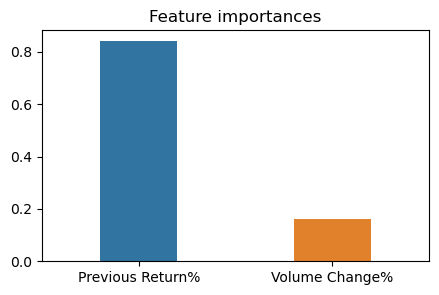

In [30]:
plt.figure(figsize=(5, 3))
sns.barplot(x=X.columns, y=abc.feature_importances_, width=0.4)
plt.title('Feature importances');